# Snake

In [130]:
from helpers import *
from environments import *
import tensorflow as tf
from datetime import datetime
import numpy as np
from IPython.display import clear_output
from  tqdm import trange
import matplotlib.pyplot as plt
import keras.api._v2.keras as K
import os
import json

## Environment definition

In [133]:
# region models
input = K.layers.Input(shape=(BaseEnvironment.BOARD_SIZE, BaseEnvironment.BOARD_SIZE, 5))
x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(input)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(8, (3, 3), activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)
x = K.layers.Flatten()(x)
policy = K.layers.Dense(64, activation=tf.nn.leaky_relu)(x)
policy = K.layers.Dense(64, activation=tf.nn.leaky_relu)(policy)
policy = K.layers.Dense(4, activation=tf.nn.softmax)(policy)
agent = K.models.Model(inputs=input, outputs=policy)




input = K.layers.Input(shape=(BaseEnvironment.BOARD_SIZE, BaseEnvironment.BOARD_SIZE, 5))
x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(input)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(64, (3, 3), activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)

x = K.layers.Conv2D(8, (3, 3), activation="linear", use_bias=False)(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Activation(tf.nn.leaky_relu)(x)
x = K.layers.Flatten()(x)
vf = K.layers.Dense(64, activation=tf.nn.leaky_relu)(x)
vf = K.layers.Dense(64, activation=tf.nn.leaky_relu)(vf)
vf = K.layers.Dense(1, activation="linear")(vf)
value = K.models.Model(inputs=input, outputs=vf)

In [132]:
try:
    last_model_trained = sorted([ f.path for f in os.scandir(f'models_unshared/') if f.is_dir() ])[-1]
    agent.load_weights(last_model_trained+f"/agent")
    value.load_weights(last_model_trained+f"/value")
    print("loaded")
except:
    pass

loaded


## Training

In [45]:
env_ = NumpyEnvironment(1000)
env_.WIN_REWARD = 1.
env_.FRUIT_REWARD = 1.
env_.ATE_HIMSELF_REWARD = .3
env_.STEP_REWARD = .0
GAMMA = .9
ITERATIONS = 20000
EPSILON = 0.1
LAMBDA_VALUE = 0.1
LAMBDA_AGENT = 0.1
I = 1
ALPHA =0.0
#fig,axs=plt.subplots(1,len(env_.boards))
#for ax, board in zip(axs, env_.boards):
#    ax.imshow(board, origin="lower")
#re_normalize_possible_actions(env_.to_state(), np.array([[.25]*4]*len(env_.boards)))

In [46]:
optimizer_value = K.optimizers.Adam(1e-3)
optimizer_agent = K.optimizers.Adam(1e-5)

In [47]:
avg_rewards = []

In [29]:
try :
    import json
    with open(f"model_unshared_fitting/trend.txt", "r") as file:
        avg_rewards = json.load(file)
    print("loaded")
except:
    pass

In [48]:
%reload_ext line_profiler

In [128]:
%matplotlib inline

eligibility_trace_agent = [tf.zeros_like(layer) for layer in agent.trainable_weights]
eligibility_trace_value = [tf.zeros_like(layer) for layer in value.trainable_weights]
losses_decoder = []
for iterations in trange(ITERATIONS):
    state = env_.to_state()

    with tf.GradientTape(persistent=True) as tape:
        # calculate distributions of actions

        original_probs = agent(
            state
        )
        # remove actions that are not available
        probs = re_normalize_possible_actions(
            env_.boards,
            original_probs + EPSILON,
        )
        # sample actions
        actions = tf.random.categorical(tf.math.log(tf.stop_gradient(probs)), 1, dtype=tf.int32)

        # MDP update
        # print("start move")
        rewards = env_.move(actions)
        # print("end move")
        new_state = tf.constant(env_.to_state())

        # TD error
        value_state = tf.constant(value(state))
        td_error = tf.constant((rewards + GAMMA * value(new_state, training=False)) - value_state) * -1  # to do gradient ascend

        # calculate the loss for both value and agent


        # maybe introduce eligibility trace to simulate n-step td, to have longer dependencies
        #actions_indexes = tf.concat((tf.range(actions.shape[0])[..., None], actions), axis=-1)
        #loss_agent = tf.stop_gradient(td_error) * tf.math.log(1e-10 + tf.gather_nd(probs, actions_indexes))[...,None]
        loss_agent = tf.stop_gradient(td_error) * -tf.losses.sparse_categorical_crossentropy(actions,probs)
        loss_value = tf.stop_gradient(td_error) * value_state

        loss_agent = tf.reduce_mean(loss_agent)
        loss_value = tf.reduce_mean(loss_value)


    # calculate gradient
    gradient_agent = tape.gradient(loss_agent, agent.trainable_weights)
    gradient_value = tape.gradient(loss_value, value.trainable_weights)
    avg_rewards.append(tf.reduce_mean(rewards))

    # update neural nets weights
    eligibility_trace_agent = [GAMMA * LAMBDA_AGENT * layer + I * gradient for layer, gradient in zip(eligibility_trace_agent, gradient_agent)]
    eligibility_trace_value = [GAMMA * LAMBDA_VALUE * layer + I * gradient for layer, gradient in zip(eligibility_trace_value, gradient_value)]
    optimizer_value.apply_gradients(zip(eligibility_trace_value, value.trainable_weights))
    optimizer_agent.apply_gradients(zip(eligibility_trace_agent, agent.trainable_weights))


    if len(avg_rewards) % 100 == 0 and len(avg_rewards) > 0:
        clear_output(wait=True)
        points = np.array(avg_rewards).reshape((-1, 100)).mean(axis=-1)
        plt.plot(points, marker=".")
        _ = plt.xlabel("iterations")
        _ = plt.ylabel("avg reward")
        plt.legend(["policy"])
        plt.show()

    if len(avg_rewards) % 100 == 0:
        with open(f"model_unshared_fitting/trend.txt", "w+") as file:
            json.dump(np.array(avg_rewards).tolist(), file)
        agent.save_weights(f"models_unshared/agent")
        value.save_weights(f"models_unshared/value")


### Random policy reward

In [25]:
random_env_ = NumpyEnvironment(1000)
random_env_.WIN_REWARD = 1.
random_env_.FRUIT_REWARD = .5
random_env_.ATE_HIMSELF_REWARD = .2
random_env_.STEP_REWARD = 0.

GAMMA = .99
ITERATIONS = 10000
EPSILON=0.1
random_rewards = []

for _ in trange(1000):
    probs = re_normalize_possible_actions(
        random_env_.boards,
        tf.repeat([[.25]*4],len(random_env_.boards), axis=0)
    )
    #sample actions
    actions =  tf.random.categorical(tf.math.log(probs), 1, dtype=tf.int32)

    # MDP update
    rewards = random_env_.move(actions)
    random_rewards.append(tf.reduce_mean(rewards))

100%|██████████| 1000/1000 [00:55<00:00, 18.07it/s]


## Training evaluation

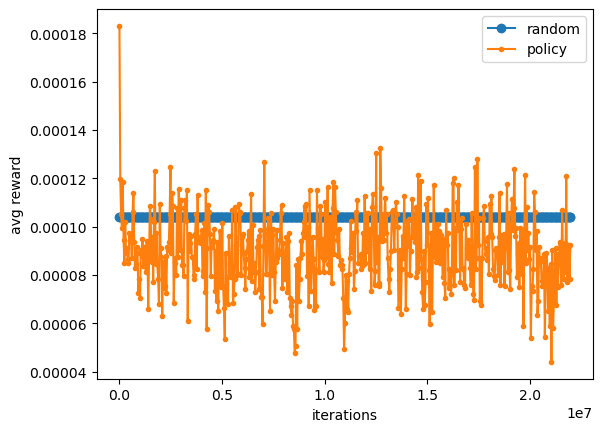

In [26]:
%matplotlib inline

CHUNK_SIZE = 200
N = len(avg_rewards)//CHUNK_SIZE*CHUNK_SIZE
x = np.linspace(0,CHUNK_SIZE*N, N//CHUNK_SIZE)
plt.plot(x, np.array(random_rewards[500:]).mean(axis=-1).repeat(N//CHUNK_SIZE), marker="o")
points = np.array(avg_rewards)[:N].reshape((-1, CHUNK_SIZE)).mean(axis=-1)
plt.plot(x, points, marker=".")
_ = plt.xlabel("iterations")
_ = plt.ylabel("avg reward")
plt.legend(["random", "policy"])

## Test (graphical simulation)

In [27]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [28]:
test_env = NumpyEnvironment(3)

In [29]:
def animate(frame):
    state = test_env.to_state()
    compressed_state = encoder(state)

    original_probs = tf.concat((agent(
        compressed_state
    )[:-1], [[.25]*4]), axis=0)

    probs = re_normalize_possible_actions(
        test_env.boards,
        original_probs
    )
    actions = tf.random.categorical(tf.math.log(probs),1)
    test_env.move(actions)
    for board, image in zip(test_env.boards, images):
        image.set_data(board)
    return images

In [30]:
fig, axs = plt.subplots(1,3, figsize=(10,5))
images = []
for b, ax in zip(test_env.boards, axs.flatten()):
    images.append(ax.imshow(b, origin="lower"))
anim = FuncAnimation(fig, animate, interval=30)

<IPython.core.display.Javascript object>